# Exploratory Data Analysis

In this document, we perform exploratory data analysis on the [brain tumour MRI dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data) [1]. The document is structured as follows:

**Table of Contents**:
1.
2.


# Requirements

We first load the requirements.

In [2]:
pip install kagglehub

We next load the dataset. This dataset is downloaded from Kaggle.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


The following Kaggle [discussion](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/discussion/482896) suggests the presence of duplicate images in the dataset. We use their provided code [2] to check for duplicates.

In [4]:
import os  # Import os module for file operations
import hashlib

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary','notumor', 'meningioma', 'glioma'] # Adjust these labels based on your dataset's folder names

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()


def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(PROJECT_DIR, 'data', 'raw', data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]


def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates : {duplicate_count}")


if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)

Number of duplicates : 0


The output of the code suggests that there are in fact no duplicates. We have double-checked this by each running this code and confirmed that there are no duplicates. We proceed, checking the class distributions in the training and test data.

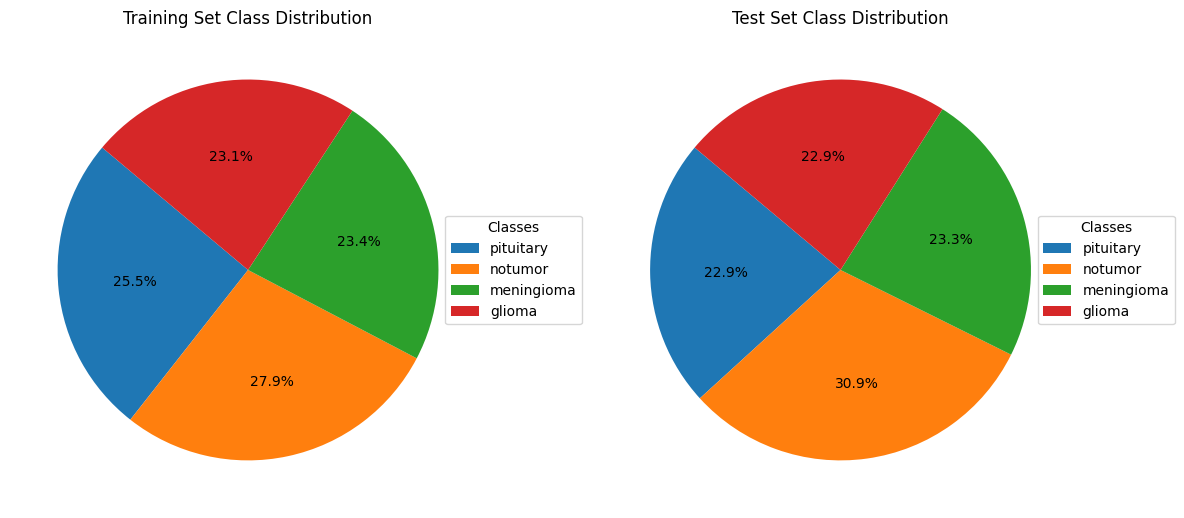

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

base_path = Path(path)
train_dir = base_path / "Training"
test_dir = base_path / "Testing"
labels = ['pituitary', 'notumor', 'meningioma', 'glioma']

def get_class_distribution(directory):
    class_counts = {}
    for label in labels:
        class_path = directory / label
        class_counts[label] = len(list(class_path.glob('*.jpg')))  # assuming images are in .jpg format
    return class_counts

train_class_counts = get_class_distribution(train_dir)
test_class_counts = get_class_distribution(test_dir)

# Training Set Pie Chart with Legend
plt.figure(figsize=(12, 6))

# Training set distribution
plt.subplot(1, 2, 1)
plt.pie(train_class_counts.values(), autopct='%1.1f%%', startangle=140)
plt.title("Training Set Class Distribution")
plt.legend(train_class_counts.keys(), title="Classes", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

# Test set distribution
plt.subplot(1, 2, 2)
plt.pie(test_class_counts.values(), autopct='%1.1f%%', startangle=140)
plt.title("Test Set Class Distribution")
plt.legend(test_class_counts.keys(), title="Classes", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

plt.tight_layout()
plt.show()

We can see that there is no problem of imbalance, as the classes are approximately evenly split in the training and test data. Next, we look at the image dimensions. This will give us an idea of how much information is stored in each image, and give us a sense of the "dimensionality" of the dataset.

We next view the actual images to understand what it looks like.

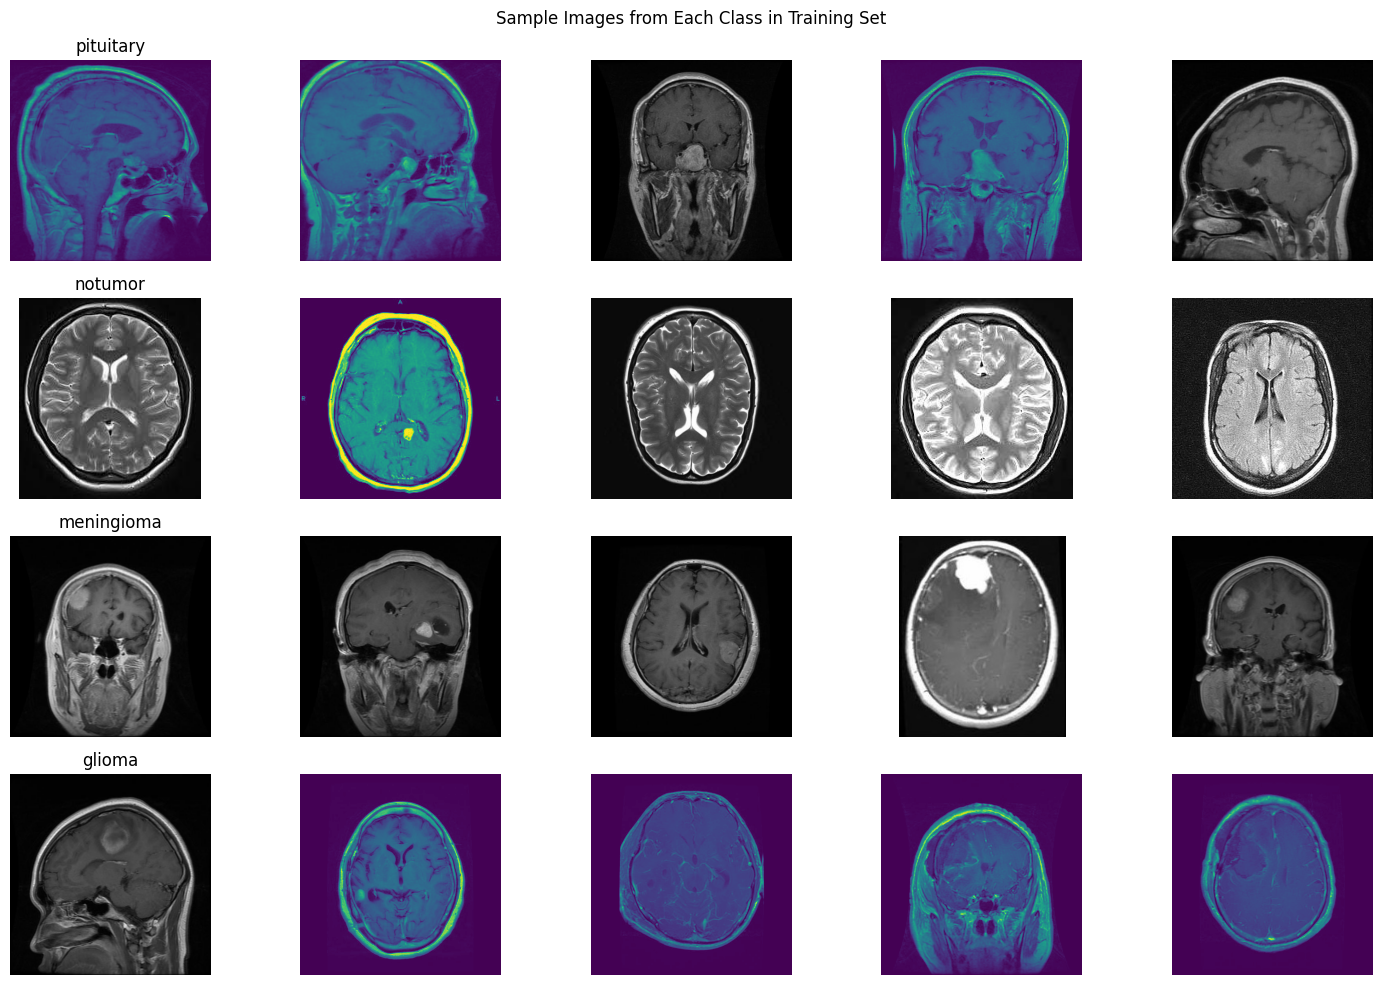

In [11]:
fig, axes = plt.subplots(len(labels), 5, figsize=(15, 10))
for idx, label in enumerate(labels):
    class_path = train_dir / label
    images = list(class_path.glob('*.jpg'))[:5]  # Get the first 5 images from each class
    for j, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[idx, j].imshow(img)
        axes[idx, j].axis('off')
        if j == 0:
            axes[idx, j].set_title(label)
plt.suptitle('Sample Images from Each Class in Training Set')
plt.tight_layout()
plt.show()


We can see that this dataset seems to have augmented images, with some images being black and white and others having colour. We can also see that there are different angles at which the MRI scans are taken, providing an insight into the information a model could use to make predictions. We can see some blobs, which are the tumours. This is clearest in the fourth image in the fourth row, with a clear white blob. To the untrained eye, it is however difficult to tell the difference between the different tumour types (meningioma,  glioma, pituitary).

## A Discussion on Image Sizes
Looking at the fourth column, we can see that the images are of different sizes. This is a problem for the model as the input layer for a neural network will be of a fixed size. While it may be possible to crop dynamically, this is an inefficient use of memory. To remedy this, we will perform pre-processing and resize the images to square 256 x 256 images. There are several advantages to doing this, compared to procedures such as padding (adding in black space instead of resizing) [3]. We briefly explain some of the advantages below:
1. Square images facilitate the use of pre-trained models. Some state-of-the-art models, such as VGGNet or ResNet, have been trained on square images. By resizing our images to a square shape, we can leverage these pre-trained models more effectively, as the input dimensions of our images match those of the pre-trained models. This enables transfer learning, where the pre-trained models' learned features can be utilized to improve the accuracy and efficiency of our own CNN models.

2. Resizing images to a square shape helps to maintain consistency in the input dimensions across the dataset. The input layer will require inputs of a fixed size. While dynamic cropping is possible, it is an inefficient use of memory and is unadvisable as we have a limited time and computational budget. By resizing all images to a square shape, we ensure that they have the same width and height, which simplifies the data handling and processing steps.

3. Resizing

To perform the resizing, we run the following pre-processing code provided by the dataset creator. We provide an explanation of what it does after the next code block.

In [ ]:
### Code provided by dataset creator, taken from https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils



def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

if __name__ == "__main__":
	training = train_dir
	testing = test_dir
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 256

	for dir in training_dir:
		save_path = 'cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

	for dir in testing_dir:
		save_path = 'cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

We can see that the images are not all the same size. To remedy this, we perform some pre-processing. We use the code provided by the dataset creator. The code does the following:
1. Crop each image to focus on the primary region of interest (likely the tumor).
2. Resize each cropped image to a standard dimension (256x256 pixels).
3. Save the processed images to a new directory structure.

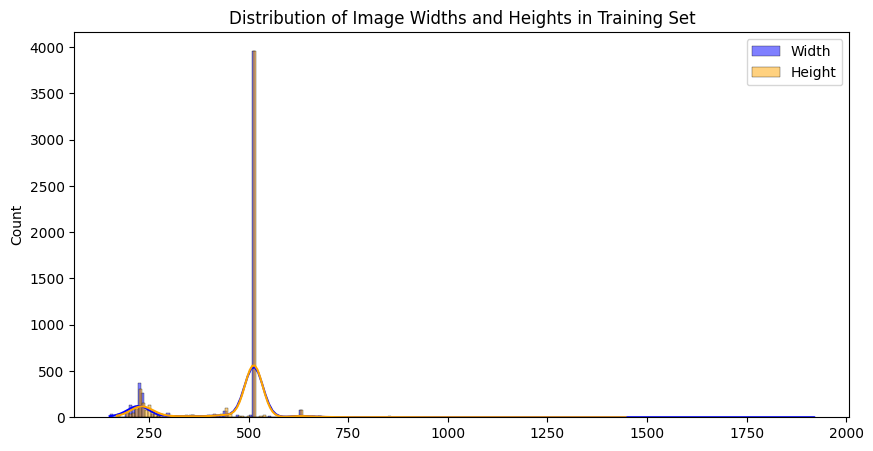

In [6]:
def get_image_dimensions(directory):
    dimensions = []
    for label in labels:
        class_path = directory / label
        for image_file in class_path.glob('*.jpg'):
            with Image.open(image_file) as img:
                dimensions.append(img.size)  # (width, height)
    return dimensions

train_dimensions = get_image_dimensions(train_dir)
widths, heights = zip(*train_dimensions)

# Plot distributions of widths and heights
plt.figure(figsize=(10, 5))
sns.histplot(widths, kde=True, color="blue", label="Width")
sns.histplot(heights, kde=True, color="orange", label="Height")
plt.legend()
plt.title('Distribution of Image Widths and Heights in Training Set')
plt.show()


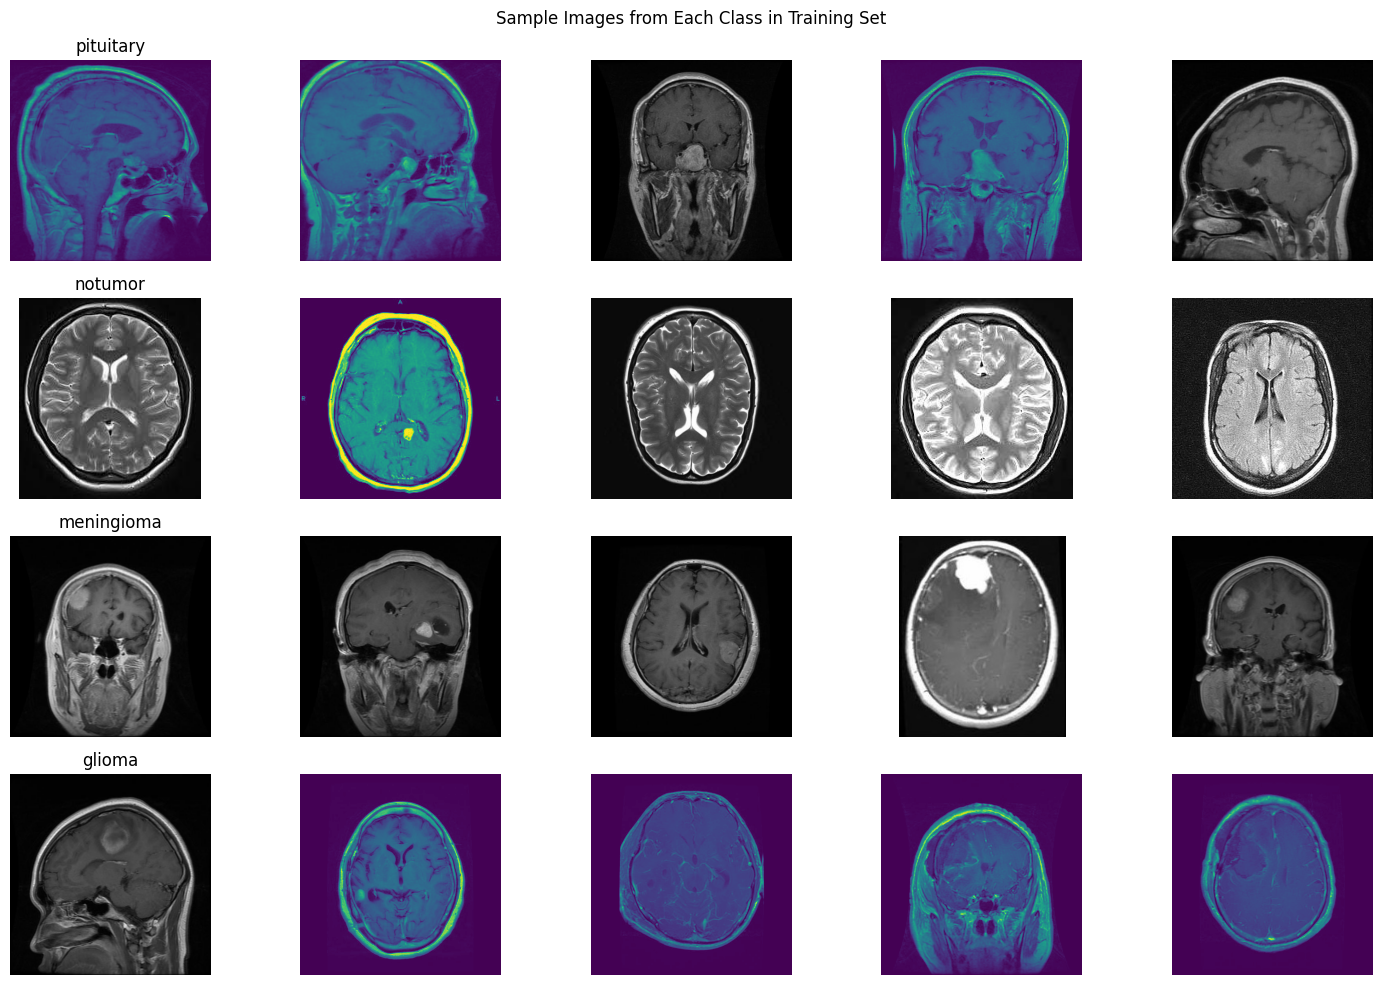

# References

[1] Brain tumour MRI dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

[2] Kaggle discussion on finding duplicates: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/discussion/482896

[3] Padding vs Resizing: https://stackoverflow.com/questions/47697622/cnn-image-resizing-vs-padding-keeping-aspect-ratio-or-not/49882055#49882055